# Image Classification Model - Serving Function
The functio accept a URL or binary image and provide prediction (0->1) using a pre=defined tensorflow model

In [ ]:
# nuclio: ignore
!pip install tensorflow==1.13.2 --upgrade

In [1]:
# nuclio: ignore
import nuclio

### Install dependencies and set config
> Note: Since tensorflow 1.13.2 is being pulled from the baseimage it is not directly installed as a build command.
If it is not installed on your system please uninstall and install using the line: `pip install tensorflow==1.13.2 keras`

In [ ]:
%%nuclio cmd 
pip install numpy==1.16.4
pip install keras requests pillow

In [2]:
%nuclio config spec.build.baseImage = "tensorflow/tensorflow:1.13.2-py3"

%nuclio: setting spec.build.baseImage to 'tensorflow/tensorflow:1.13.2-py3'


## Set function environment variables

In [3]:
%%nuclio env 
IMAGE_WIDTH=128
IMAGE_HEIGHT=128

%nuclio: setting 'IMAGE_WIDTH' environment variable
%nuclio: setting 'IMAGE_HEIGHT' environment variable


## Function Code

In [4]:
import json
import numpy as np
import requests
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from os import environ, path
from PIL import Image
from io import BytesIO
from urllib.request import urlopen

Using TensorFlow backend.


### Model Serving Class

In [6]:
class TFModel(object):
    def __init__(self, name: str, model_dir: str):
        self.name = name
        self.model_filepath = model_dir
        self.model = None
        self.ready = None

        self.IMAGE_WIDTH = int(environ['IMAGE_WIDTH'])
        self.IMAGE_HEIGHT = int(environ['IMAGE_HEIGHT'])
        
        try:
            print(environ['classes_map'])
            with open(environ['classes_map'], 'r') as f:
                self.classes = json.load(f)
        except:
            self.classes = None
        
        print(f'Classes: {self.classes}')

    def load(self):
        self.model = load_model(self.model_filepath)

        self.ready = True

    def _download_file(self, url, target_path):
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(target_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)

    def predict(self, context, data):
        #try:
        print(self.classes)
        img = Image.open(BytesIO(data))
        img = img.resize((self.IMAGE_WIDTH, self.IMAGE_HEIGHT))

        # Load image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])

        # Predict
        predicted_probability = self.model.predict(images)

        # return prediction
        if self.classes:
            predicted_classes = np.around(predicted_probability, 1).tolist()[0]
            predicted_probabilities = predicted_probability.tolist()[0]
            print(predicted_classes)
            print(predicted_probabilities)
            return {
                'prediction': [self.classes[str(int(cls))] for cls in predicted_classes], 
                f'{self.classes["1"]}-probability': predicted_probabilities
            }
        else:
            return predicted_probability.tolist()[0]

       # except Exception as e:
       #     raise Exception("Failed to predict {}".format(e))

### Routes

In [7]:
def predict(context, model_name, event):
    global models
    global protocol

    # Load the requested model
    model = models[model_name]

    # Verify model is loaded (Async)
    if not model.ready:
        model.load()
    
    # extract image data from event
    try:
        data = event.body
        ctype = event.content_type
        if not ctype or ctype.startswith('text/plain'):
            # Get image from URL
            url = data.decode('utf-8')
            context.logger.debug_with('downloading image', url=url)
            data = urlopen(url).read()
            
    except Exception as e:
        raise Exception("Failed to get data: {}".format(e))                
            
    # Predict
    results = model.predict(context, data)
    context.logger.info(results)

    # Wrap & return response
    return context.Response(body=json.dumps(results),
                            headers={},
                            content_type='text/plain',
                            status_code=200)

# Router
paths = {
    'predict': predict,
    'explain': '',
    'outlier_detector': '',
    'metrics': '',
}

### Main

In [8]:
# Definitions
model_prefix = 'SERVING_MODEL_'
models = {}

def init_context(context):
    global models
    global model_prefix

    # Initialize models from environment variables
    # Using the {model_prefix}_{model_name} = {model_path} syntax
    model_paths = {k[len(model_prefix):]: v for k, v in environ.items() if
                   k.startswith(model_prefix)}

    models = {name: TFModel(name=name, model_dir=path) for name, path in
              model_paths.items()}
    context.logger.info(f'Loaded {list(models.keys())}')

In [9]:
err_string = 'Got path: {}\nPath must be <host>/<action>/<model-name> \nactions: {} \nmodels: {}'

def handler(context, event):
    global models
    global paths

    # check if valid route & model
    sp_path = event.path.strip('/').split('/')
    if len(sp_path) < 2 or sp_path[0] not in paths or sp_path[1] not in models:
        return context.Response(body=err_string.format(event.path, '|'.join(paths), '|'.join(models.keys())),
                                content_type='text/plain',
                                status_code=400)
        
    function_path = sp_path[0] 
    model_name = sp_path[1]

    context.logger.info(
        f'Serving uri: {event.path} for route {function_path} '
        f'with {model_name}, content type: {event.content_type}')

    route = paths.get(function_path)
    if route:
        return route(context, model_name, event)

    return context.Response(body='function {} not implemented'.format(function_path),
                            content_type='text/plain',
                            status_code=400)

In [10]:
# nuclio: end-code

## Test the function locally

Make sure your local TF / Keras version is the same as pulled in the nuclio image for accurate testing

Set the served models and their file paths using: `SERVING_MODEL_<name> = <model file path>`

> Note: this notebook assumes the model and categories are under <b>/User/mlrun/examples/</b>

In [11]:
base_dir = os.getcwd()
environ['SERVING_MODEL_cat_dog_v1'] = base_dir + 'models/cats_n_dogs.h5'
environ['classes_map'] = base_dir + 'images/categories_map.json'

init_context(context)

/User/mlrun/examples/images/categories_map.json
Classes: {'0': 'cat', '1': 'dog'}
Python> 2019-11-10 19:25:44,372 [info] Loaded ['cat_dog_v1']


Python> 2019-11-10 19:25:55,405 [info] Serving uri: /predict/cat_dog_v1 for route predict with cat_dog_v1, content type: image/jpeg
{'0': 'cat', '1': 'dog'}
[0.0]
[0.0]
Python> 2019-11-10 19:25:55,437 [info] {'prediction': ['cat'], 'dog-probability': [0.0]}
{"prediction": ["cat"], "dog-probability": [0.0]}


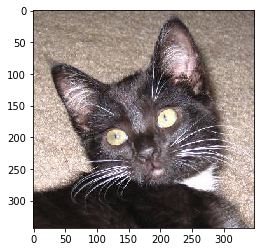

In [13]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

cat_image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/cat.102.jpg'
response = requests.get(cat_image_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

model_name = 'cat_dog_v1'
event = nuclio.Event(body=response.content,
                     content_type='image/jpeg',
                     path=f'/predict/{model_name}')
output = handler(context, event)
print(str(output.body))

## Deploy the serving function to the cluster

In [14]:
# convert the notebook code to deployable function, configure it
from mlrun import code_to_function
fn = code_to_function('tf-image-server-from-notebook', runtime='nuclio')

# set the API/trigger, attach the home dir to the function
fn.with_http(workers=2).add_volume('User','~/')

# set the model file path SERVING_MODEL_<name> = <model file path>
fn.set_env('SERVING_MODEL_cat_dog_v1', base_dir + 'models/cats_n_dogs.h5')
fn.set_env('classes_map', base_dir + 'images/categories_map.json')

In [15]:
# deploy the function to the cluster
addr = fn.deploy(project='nuclio-serving')

[mlrun] 2019-11-10 19:26:07,302 deploy started
[nuclio.deploy] 2019-11-10 19:26:08,375 (info) Building processor image
[nuclio.deploy] 2019-11-10 19:26:13,416 (info) Build complete
[nuclio.deploy] 2019-11-10 19:26:19,521 (info) Function deploy complete
[nuclio.deploy] 2019-11-10 19:26:19,527 done updating tf-image-server-from-notebook, function address: 13.58.34.174:31680


### Test the real function (with URL)

{"prediction": ["dog"], "dog-probability": [1.0]}


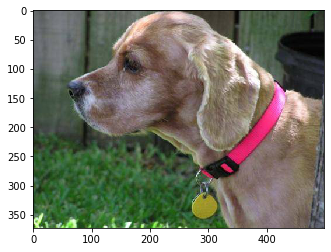

In [16]:
dog_image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/dog.102.jpg'
response = requests.get(dog_image_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

headers = {'Content-type': 'text/plain'}
response = requests.post(url=addr + f'/predict/{model_name}', data=dog_image_url, headers=headers)
print(response.content.decode('utf-8'))

### Test the real function (with Jpeg Image)

{"prediction": ["cat"], "dog-probability": [1.1800089838134144e-33]}


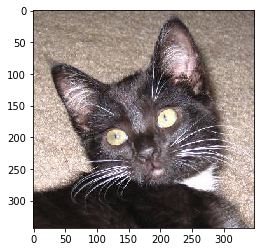

In [17]:
cat_image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/cat.102.jpg'
response = requests.get(cat_image_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

headers = {'Content-type': 'image/jpeg'}
response = requests.post(url=addr + f'/predict/{model_name}', data=response.content, headers=headers)
print(response.content.decode('utf-8'))